In [1]:
import pandas as pd

pd.set_option("display.width", 5000)
import seaborn as sns
import matplotlib.pyplot as plt


from utils.utils import plot_recall_correlations, plot_scores

df_sovanta_ret = pd.read_csv("eval-judges-ret-sov-2025-05-27_10_14_56-fixed.csv")
df_wikieval_ret = pd.read_csv("eval-judges-ret-wikieval-2025-05-13_14_30_15.csv")
print(df_wikieval_ret.shape)
print(df_sovanta_ret.shape)

wikieval_cols = [
    col for col in df_wikieval_ret.columns if ("relevance" in col or "groundedness" in col) and "_meta" not in col
]
sov_cols = [
    col for col in df_sovanta_ret.columns if ("relevance" in col or "groundedness" in col) and "_meta" not in col
]
judges = [
    "gpt-4o-mini",
    "gpt-4o",
    "meta--llama3.1-70b-instruct",
    "mistralai--mistral-large-instruct",
    "anthropic--claude-3.7-sonnet",
]
sovanta_judges = ["meta--llama3.1-70b-instruct", "mistralai--mistral-large-instruct"]

(320, 53)
(480, 35)


# 1. Failure Rate of the different Judges

In [2]:
print("----------- Wikieval Data  ------------")
for col in wikieval_cols:
    fails = 0
    df_f = df_wikieval_ret[df_wikieval_ret[col].isna()]
    print(f"Failure rate of {col}: {len(df_f) / len(df_wikieval_ret)}")

print("----------- sovanta Data  ------------")
for col in sov_cols:
    fails = 0
    df_f = df_sovanta_ret[df_sovanta_ret[col].isna()]
    print(f"Failure rate of {col}: {len(df_f) / len(df_sovanta_ret)}")

----------- Wikieval Data  ------------
Failure rate of gpt-4o-mini_context_relevance: 0.0
Failure rate of gpt-4o-mini_context_relevance_max_10: 0.0
Failure rate of gpt-4o-mini_context_relevance_with_cot: 0.0
Failure rate of gpt-4o_context_relevance: 0.0
Failure rate of gpt-4o_context_relevance_max_10: 0.0
Failure rate of gpt-4o_context_relevance_with_cot: 0.0
Failure rate of meta--llama3.1-70b-instruct_context_relevance: 0.0
Failure rate of meta--llama3.1-70b-instruct_context_relevance_max_10: 0.0
Failure rate of meta--llama3.1-70b-instruct_context_relevance_with_cot: 0.0
Failure rate of mistralai--mistral-large-instruct_context_relevance: 0.0
Failure rate of mistralai--mistral-large-instruct_context_relevance_max_10: 0.0
Failure rate of mistralai--mistral-large-instruct_context_relevance_with_cot: 0.0
Failure rate of anthropic--claude-3.7-sonnet_context_relevance: 0.0
Failure rate of anthropic--claude-3.7-sonnet_context_relevance_max_10: 0.0
Failure rate of anthropic--claude-3.7-sonn

## 2. Context Relevance Evaluation
### 2.1 Wikieval
Correlation with Nodes Recall

In [3]:
correlations = []
useful_cols = []
for col in wikieval_cols:
    corr = df_wikieval_ret["nodes_recall_0.5"].corr(df_wikieval_ret[col])
    correlations.append((col, corr))
    if corr > 0.3:
        useful_cols.append(col)
correlations.sort(key=lambda x: x[1], reverse=True)
for col, corr in correlations:
    print(f"{col}: {corr}")

gpt-4o_context_relevance_with_cot: 0.44971111835874916
anthropic--claude-3.7-sonnet_context_relevance_with_cot: 0.3951644103793439
anthropic--claude-3.7-sonnet_context_relevance: 0.3671727001943689
gpt-4o-mini_context_relevance_with_cot: 0.32770470490728887
anthropic--claude-3.7-sonnet_context_relevance_max_10: 0.31376053765851813
mistralai--mistral-large-instruct_context_relevance_with_cot: 0.2909783701935185
gpt-4o_context_relevance_max_10: 0.26108136669833354
gpt-4o_context_relevance: 0.24381356493181727
mistralai--mistral-large-instruct_context_relevance_max_10: 0.24164616449349838
meta--llama3.1-70b-instruct_context_relevance_with_cot: 0.24005941699650724
mistralai--mistral-large-instruct_context_relevance: 0.18032672683945133
meta--llama3.1-70b-instruct_context_relevance: -0.02412176838973924
gpt-4o-mini_context_relevance_max_10: -0.09624157642083445
gpt-4o-mini_context_relevance: -0.0990736319600803
meta--llama3.1-70b-instruct_context_relevance_max_10: -0.18711366497632329


Grouped Scores per Metric

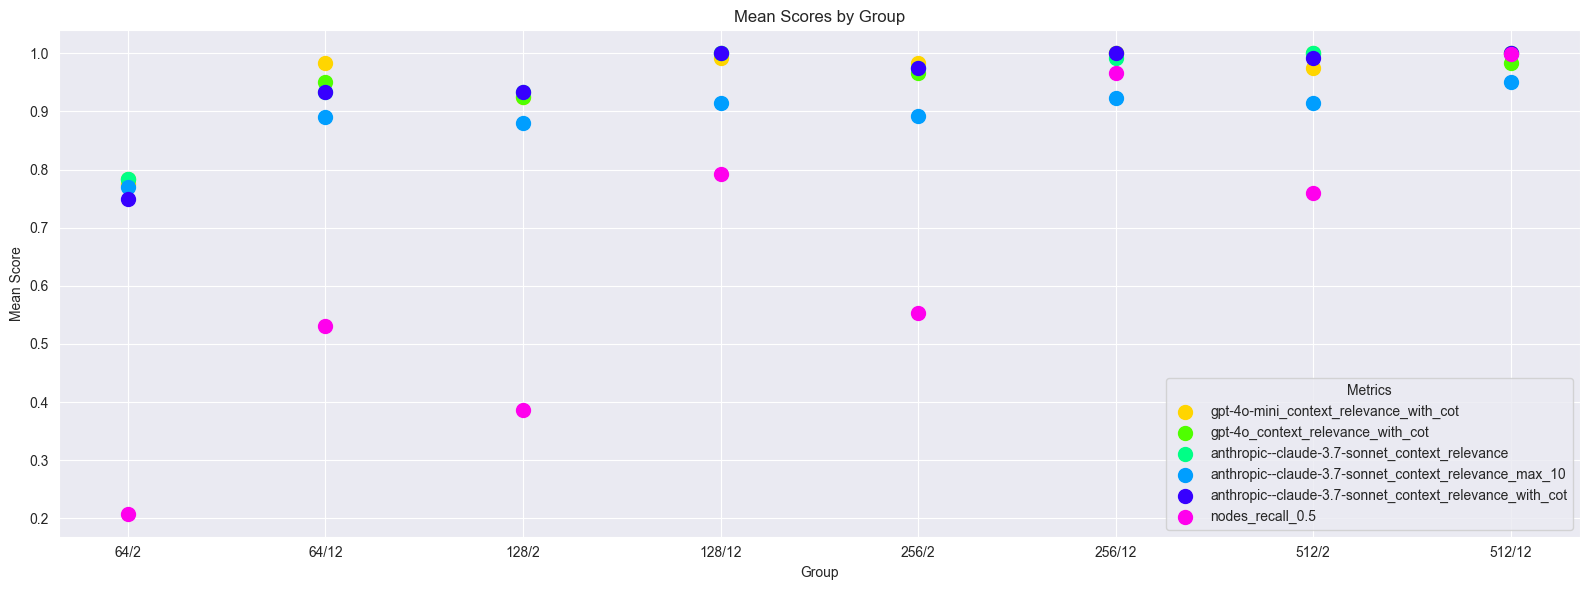

Overall mean values:
gpt-4o-mini_context_relevance_with_cot                     0.954167
anthropic--claude-3.7-sonnet_context_relevance             0.952083
gpt-4o_context_relevance_with_cot                          0.951042
anthropic--claude-3.7-sonnet_context_relevance_with_cot    0.947917
anthropic--claude-3.7-sonnet_context_relevance_max_10      0.891875
nodes_recall_0.5                                           0.649579
dtype: float64


In [4]:
plot_scores(df_wikieval_ret, "chunk_top_k", columns_to_plot=useful_cols + ["nodes_recall_0.5"])

Correlation between the Models

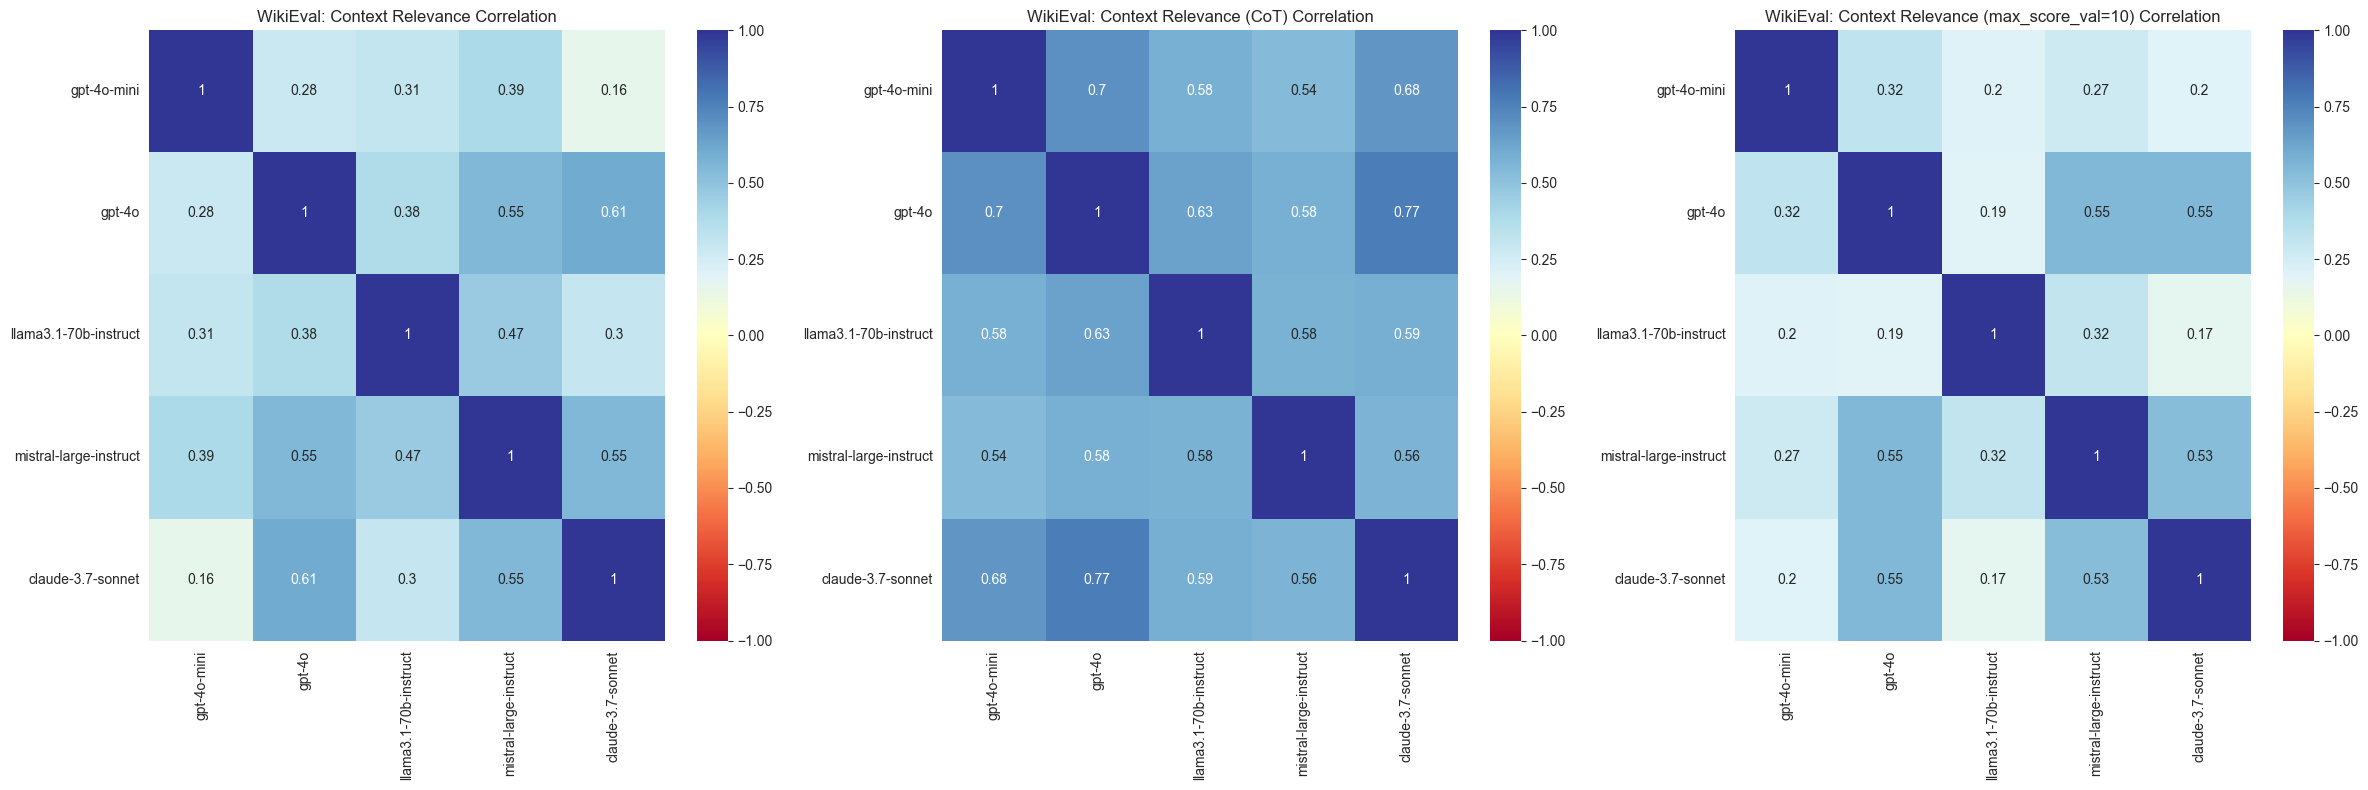

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

context_rel_cols = [f"{judge}_context_relevance" for judge in judges]
context_rel_cot_cols = [f"{judge}_context_relevance_with_cot" for judge in judges]
context_rel_10_cols = [f"{judge}_context_relevance_max_10" for judge in judges]

corr_context = df_wikieval_ret[context_rel_cols].corr()
corr_context_cot = df_wikieval_ret[context_rel_cot_cols].corr()
corr_context_10 = df_wikieval_ret[context_rel_10_cols].corr()

sns.heatmap(
    corr_context,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=[j.split("--")[-1] for j in judges],
    yticklabels=[j.split("--")[-1] for j in judges],
    ax=ax1,
)
ax1.set_title("WikiEval: Context Relevance Correlation")

sns.heatmap(
    corr_context_cot,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=[j.split("--")[-1] for j in judges],
    yticklabels=[j.split("--")[-1] for j in judges],
    ax=ax2,
)
ax2.set_title("WikiEval: Context Relevance (CoT) Correlation")

sns.heatmap(
    corr_context_10,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=[j.split("--")[-1] for j in judges],
    yticklabels=[j.split("--")[-1] for j in judges],
    ax=ax3,
)
ax3.set_title("WikiEval: Context Relevance (max_score_val=10) Correlation")

plt.tight_layout()
plt.show()

Now, lets see how these correlations depend on different parameters

/Users/johann.zapf/PycharmProjects/masterthesis/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/johann.zapf/PycharmProjects/masterthesis/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


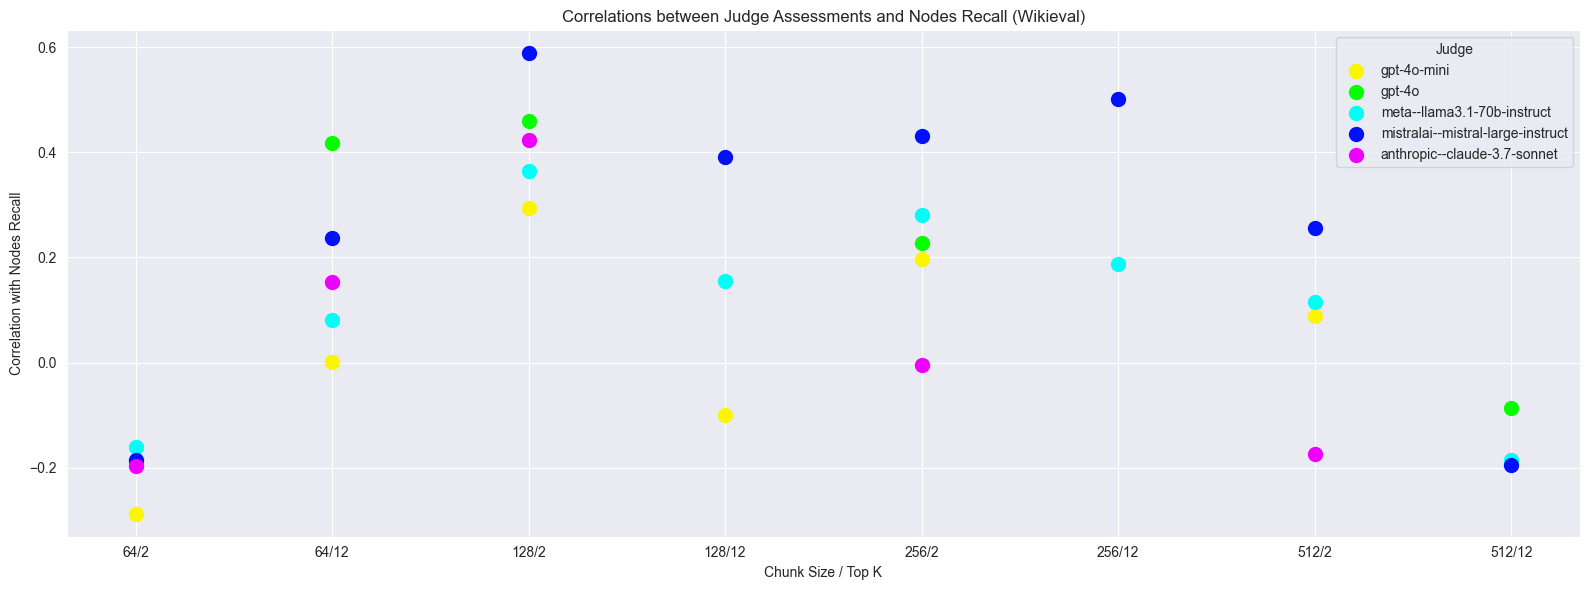

In [6]:
plot_recall_correlations(
    df_wikieval_ret,
    judges,
    group_by=["chunk_size", "top_k"],
    context_col_template="{judge}_context_relevance_with_cot",
    title="Correlations between Judge Assessments and Nodes Recall (Wikieval)",
)

## 2.2 Sovanta
Correlation wit Nodes Recall

In [7]:
correlations = []
useful_cols = []
for col in sov_cols:
    corr = df_sovanta_ret["nodes_recall_0.5"].corr(df_sovanta_ret[col])
    correlations.append((col, corr))
    if corr > 0.02:
        useful_cols.append(col)
correlations.sort(key=lambda x: x[1], reverse=True)
for col, corr in correlations:
    print(f"{col}: {corr}")

meta--llama3.1-70b-instruct_context_relevance_with_cot: 0.10551658754968218
mistralai--mistral-large-instruct_context_relevance_with_cot: 0.09987550610549582
mistralai--mistral-large-instruct_context_relevance: 0.06291088832418487
meta--llama3.1-70b-instruct_context_relevance: 0.02706639557546054
meta--llama3.1-70b-instruct_context_relevance_max_10: 0.00415903327460275
mistralai--mistral-large-instruct_context_relevance_max_10: -0.00896052913899305


Grouped Scores per Metric

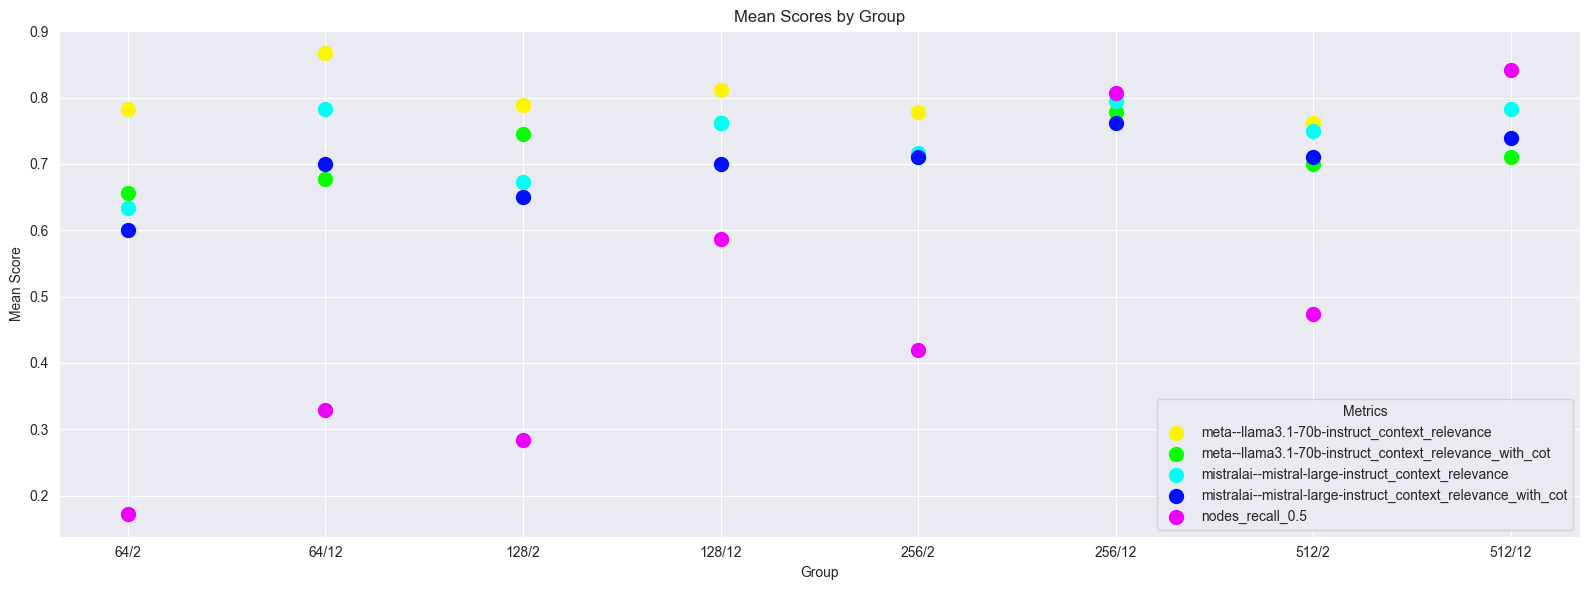

Overall mean values:
meta--llama3.1-70b-instruct_context_relevance                   0.795833
mistralai--mistral-large-instruct_context_relevance             0.736806
meta--llama3.1-70b-instruct_context_relevance_with_cot          0.717361
mistralai--mistral-large-instruct_context_relevance_with_cot    0.696528
nodes_recall_0.5                                                0.489269
dtype: float64


In [8]:
plot_scores(df_sovanta_ret, "chunk_top_k", columns_to_plot=useful_cols + ["nodes_recall_0.5"])

Correlation between the models

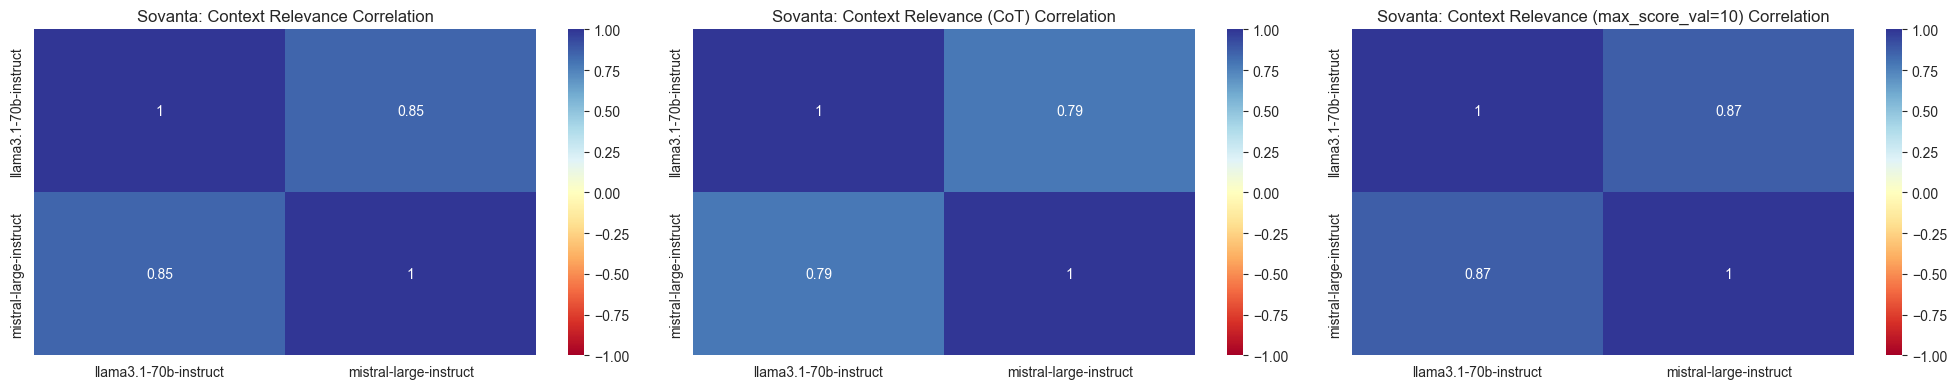

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

context_rel_cols = [f"{judge}_context_relevance" for judge in sovanta_judges]
context_rel_cot_cols = [f"{judge}_context_relevance_with_cot" for judge in sovanta_judges]
context_rel_10_cols = [f"{judge}_context_relevance_max_10" for judge in sovanta_judges]

corr_context = df_sovanta_ret[context_rel_cols].corr()
corr_context_cot = df_sovanta_ret[context_rel_cot_cols].corr()
corr_context_10 = df_sovanta_ret[context_rel_10_cols].corr()

sns.heatmap(
    corr_context,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=[j.split("--")[-1] for j in sovanta_judges],
    yticklabels=[j.split("--")[-1] for j in sovanta_judges],
    ax=ax1,
)
ax1.set_title("Sovanta: Context Relevance Correlation")

sns.heatmap(
    corr_context_cot,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=[j.split("--")[-1] for j in sovanta_judges],
    yticklabels=[j.split("--")[-1] for j in sovanta_judges],
    ax=ax2,
)
ax2.set_title("Sovanta: Context Relevance (CoT) Correlation")

sns.heatmap(
    corr_context_10,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=[j.split("--")[-1] for j in sovanta_judges],
    yticklabels=[j.split("--")[-1] for j in sovanta_judges],
    ax=ax3,
)
ax3.set_title("Sovanta: Context Relevance (max_score_val=10) Correlation")

plt.tight_layout()
plt.show()

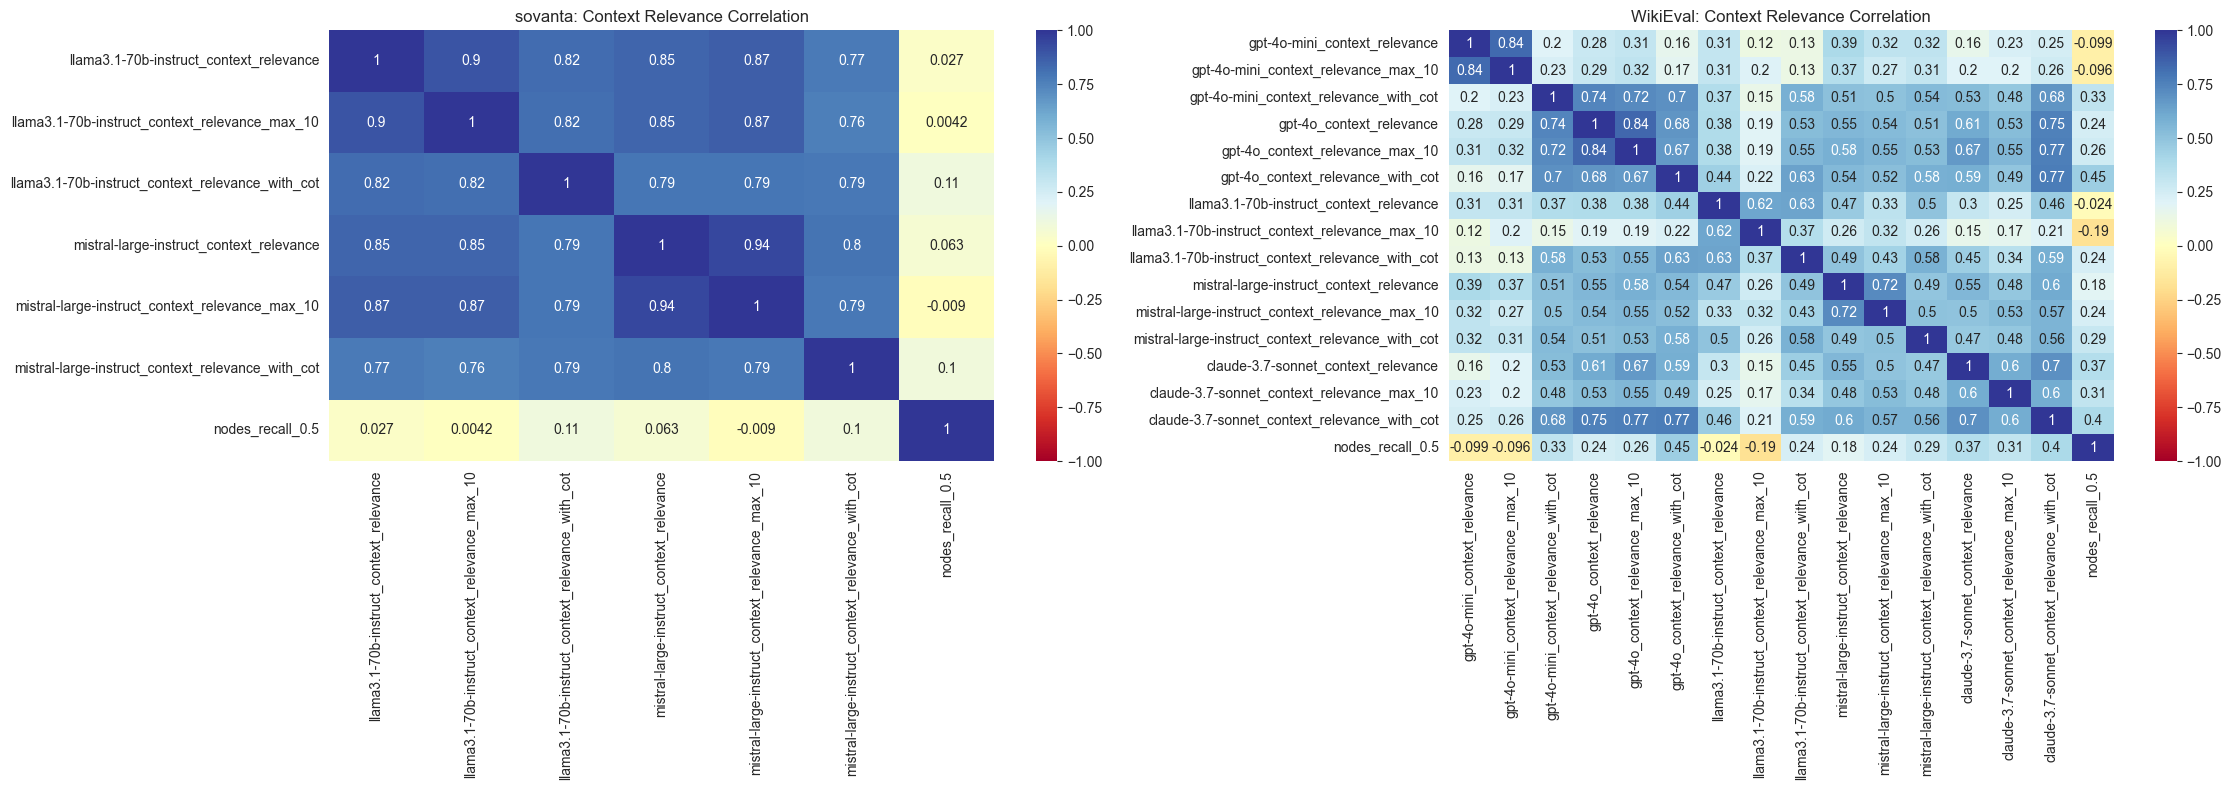

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 8))

sov_cols = [col for col in df_sovanta_ret.columns if "context_relevance" in col and "_meta" not in col] + [
    "nodes_recall_0.5"
]
wik_cols = [col for col in df_wikieval_ret.columns if "context_relevance" in col and "_meta" not in col] + [
    "nodes_recall_0.5"
]

corr_sov = df_sovanta_ret[sov_cols].corr()
corr_wik = df_wikieval_ret[wik_cols].corr()

sns.heatmap(
    corr_sov,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=[j.split("--")[-1] for j in sov_cols],
    yticklabels=[j.split("--")[-1] for j in sov_cols],
    ax=ax1,
)
ax1.set_title("sovanta: Context Relevance Correlation")

sns.heatmap(
    corr_wik,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=[j.split("--")[-1] for j in wik_cols],
    yticklabels=[j.split("--")[-1] for j in wik_cols],
    ax=ax2,
)
ax2.set_title("WikiEval: Context Relevance Correlation")

plt.tight_layout()
plt.show()

# 3. Conclusions
## 3.1 Wikieval
- gpt-4o with CoT has the highest correlation with recall at 0.45 -> strongest LLM with CoT
- using CoT strongly improves the correlation between the different LLMs and with recall
- it does not really make a difference whether we score from 1-3 or from 1-10
## 3.2 sovanta
- llama3.1 with CoT has the highest correlation at 0.11
- the reason for the lower performance is most likely the way more complex dataset
- the correlation between the models is relatively similar, no matter which configuration
- in terms of correlation with recall, CoT is better than 1-3, which is better than 1-10
## 3.3 General
- all judges are equally able to score context relevance without errors
- unsurprisingly, the results are higher the better the LLM
- all LLMs score the context relevance in general too high, which is likely because they have no notion of "missing" evidence

--> Why is the correlation so bad? Lets look at an example

In [11]:
from utils.utils import PNode

row = df_sovanta_ret.iloc[3]
nodes = pd.eval(row["nodes"], local_dict={"PNode": PNode})
print("Question: ", row["prompt"])
print("Retrieved Text: \n", "\n".join([n.text for n in nodes]))
print("\n-----------------------\nNodes Recall: ", row["nodes_recall_0.5"])
print(
    "GPT-4o Context Relevance with CoT: ",
    row["meta--llama3.1-70b-instruct_context_relevance_with_cot"],
)

Question:  Was ist Experience Managemenet
Retrieved Text: 
 a broad discipline which includes a client’s interactions with its clients (“CX”, or customer experience”),
* **Qualtrics XM is the industry-leading platform for experience management**, a broad discipline which includes a client’s interactions with its clients (“CX”,

-----------------------
Nodes Recall:  0.0
GPT-4o Context Relevance with CoT:  1.0
